# Cepstrum watermarking

In [ ]:
import librosa
import numpy as np
import scipy
from matplotlib import pyplot as plt
from acoustics.cepstrum import complex_cepstrum, inverse_complex_cepstrum

In [16]:
# read audio data
x, sr = librosa.load("sample.wav",sr=None)

# frame segmentation
sig_length = len(x)
frame_length = 4096
hop_length = 2048
overlap = frame_length - hop_length
Nframe = int( (sig_length-overlap) / hop_length)

# Hann window
win = scipy.signal.windows.hann(frame_length)

# message generation
if_repetitive_coding = True
if if_repetitive_coding:
    repeat = 3
    msg_len = int(Nframe/repeat)
else:
    repeat = 1
    msg_len = Nframe
        
msg = np.random.randint(2, size=msg_len)
print(msg)

[0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0
 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1
 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


In [17]:
# watermark strength
alpha1 = 0.0015
alpha0 = -0.0015

prev = np.zeros(frame_length)

In [18]:
# embedding loop
embedded_x = np.copy(x)

for frame_idx in range(Nframe):
    start = librosa.frames_to_samples(frame_idx,hop_length=hop_length)
    frame = x[start:start+frame_length]
    
    if frame_idx//repeat < msg_len:
        msg_bit = msg[frame_idx//repeat]
        
        alpha = alpha1 if msg_bit==1 else alpha0
    else:
        alpha = 0
    
    ccep, ndelay = complex_cepstrum(frame)
    ccep_mod = ccep - np.mean(ccep) + alpha
    
    windowed = inverse_complex_cepstrum(ccep_mod,ndelay) * win
    
    prev_ovlp_begin, curr_non_ovlp_begin = hop_length, frame_length - hop_length
    curr_ovlp_end = frame_length - hop_length
    
    smoothed = np.append(prev[prev_ovlp_begin:] + windowed[:curr_non_ovlp_begin],
                         windowed[curr_ovlp_end:])
    
    embedded_x[start:start+frame_length] = smoothed
    prev = smoothed


    

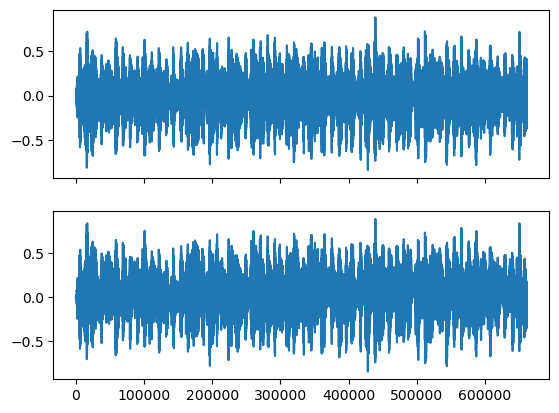

In [19]:
# visualization
ax1 = plt.subplot(211)
plt.plot(x)
plt.tick_params('x', labelbottom=False)
ax2 = plt.subplot(212, sharex = ax1)
plt.plot(embedded_x)

## Watermark decoding

In [20]:
stream_decode = np.empty(msg.shape)
for frame_idx in range(Nframe):
    start = librosa.frames_to_samples(frame_idx,hop_length=hop_length)
    frame = embedded_x[start:start+frame_length]
    decision = 0
    
    if frame_idx//repeat < msg_len:
        
        ccep, _ = complex_cepstrum(frame)
        msg_bit_decode = np.sign(np.mean(ccep))
        
        decision += msg_bit_decode
        
        if frame_idx%repeat == repeat-1:
            stream_decode[frame_idx//repeat] = 1 if decision>0 else 0
        
    else:
        break

In [21]:
ber = np.sum(np.abs(stream_decode - msg)) / len(msg)
print(f"BER:{ber}")

BER:0.4392523364485981


In [22]:
stream_decode

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [23]:
msg

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])